# Project Setup

In this project, I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. I'll train this classifier, then export it for use in a command-line application. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use trained model to perform inference on flower images.

## Install Datasets, Update TensorFlow and Make Imports

In [2]:
%pip --no-cache-dir install tensorflow-datasets 
%pip --no-cache-dir install tfds-nightly 
%pip --no-cache-dir install --upgrade tensorflow 

You should consider upgrading via the '/home/rachel/.pyenv/versions/lewagon/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 1.2 MB/s eta 0:00:001.2 MB/s eta 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 KB 1.3 MB/s eta 0:00:0078.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/rachel/.pyenv/versions/lewagon/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.8 MB/s eta 0:00:00m eta 0:00:010:00:04


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 4.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.7 MB/s eta 0:00:006.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 3.9 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 3.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 6.9 MB/s eta 0:00:00 MB/s eta 0:00:01
  Attempting uninstall: libclang
    Found existing installation: libclang 12.0.0


    Uninstalling libclang-12.0.0:
      Successfully uninstalled libclang-12.0.0
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.12.0
    Uninstalling absl-py-0.12.0:
      Successfully uninstalled absl-py-0.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0


In [17]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Other necessary imports
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import logging
import warnings
from PIL import Image

# Ignore some warnings that are not relevant 
warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

# Adjust settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [18]:
# Load the dataset with TensorFlow Datasets
ds, info = tfds.load('oxford_flowers102', as_supervised = True, with_info=True)
# Create a training set, a validation set and a test set
train, validation, test = ds['train'], ds['validation'], ds['test']

## Explore the Dataset

In [3]:
# Get the number of examples in each set from the dataset info
print(f"Number of training examples: {tf.data.experimental.cardinality(train)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(validation)}")
print(f"Number of test examples: {tf.data.experimental.cardinality(test)}\n")
# Get the number of classes in the dataset from the dataset info
print(f"Number of flower types {info.features['label'].num_classes}")

Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149

Number of flower types 102


In [4]:
# Print the shape and corresponding label of 3 images in the training set
for image, label in train.take(3):
    shape = image.numpy().shape
    label = label.numpy()
    print(shape, label)

(500, 667, 3) 72
(500, 666, 3) 84
(670, 500, 3) 70


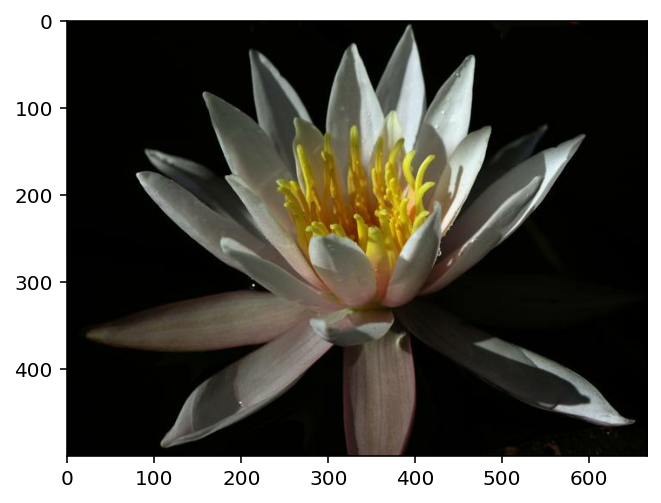

In [5]:
#  Plot 1 image from the training set
for image, label in train.take(1):
    image = image.numpy()
plt.imshow(image)
plt.show()

### Label Mapping

In [6]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

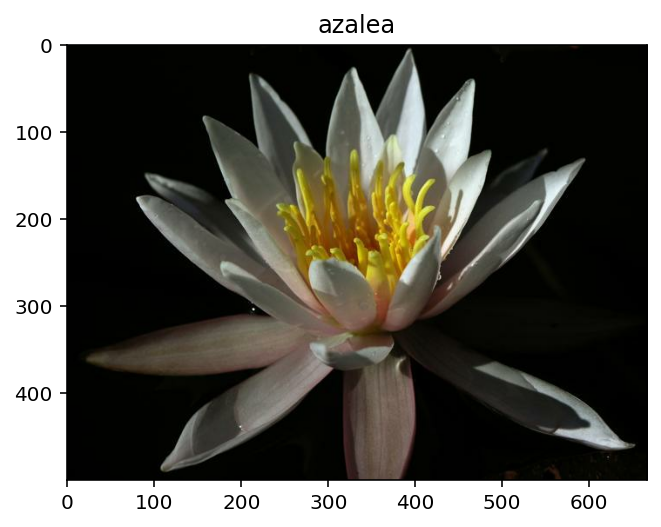

In [7]:
# Plot 1 image from the training set with correct label as title
for image, label in train.take(1):
    image = image.numpy()
    label = str(label.numpy())
plt.imshow(image)
plt.title(class_names.get(label))
plt.show()

## Create Pipeline

In [8]:
# Create a pipeline for each set.
batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

num_training_examples = tf.data.experimental.cardinality(train)

training_batches = train.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test.map(format_image).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. I'm going to use the MobileNet pre-trained model from TensorFlow Hub to get the image features, then build and train a new feed-forward classifier using those features.

In [9]:
# Build and train the network
URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
feature_extractor.trainable = False
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dropout(0.5), 
                             tf.keras.layers.Dense(102, activation = 'softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5508713   
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 102)               102204    
                                                                 
Total params: 5,610,917
Trainable params: 102,204
Non-trainable params: 5,508,713
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
EPOCHS = 5

history=model.fit(training_batches,epochs=EPOCHS,validation_data=validation_batches)

Epoch 1/5
32/32 [==============================] - 23s 621ms/step - loss: 6.0428 - accuracy: 0.0245 - val_loss: 3.2812 - val_accuracy: 0.2824
Epoch 2/5
32/32 [==============================] - 18s 555ms/step - loss: 3.4249 - accuracy: 0.2490 - val_loss: 1.9404 - val_accuracy: 0.6088
Epoch 3/5
32/32 [==============================] - 17s 547ms/step - loss: 2.0412 - accuracy: 0.4863 - val_loss: 1.3939 - val_accuracy: 0.7078
Epoch 4/5
32/32 [==============================] - 18s 581ms/step - loss: 1.3255 - accuracy: 0.6667 - val_loss: 1.1186 - val_accuracy: 0.7569
Epoch 5/5
32/32 [==============================] - 18s 559ms/step - loss: 0.8910 - accuracy: 0.7608 - val_loss: 0.9608 - val_accuracy: 0.7873


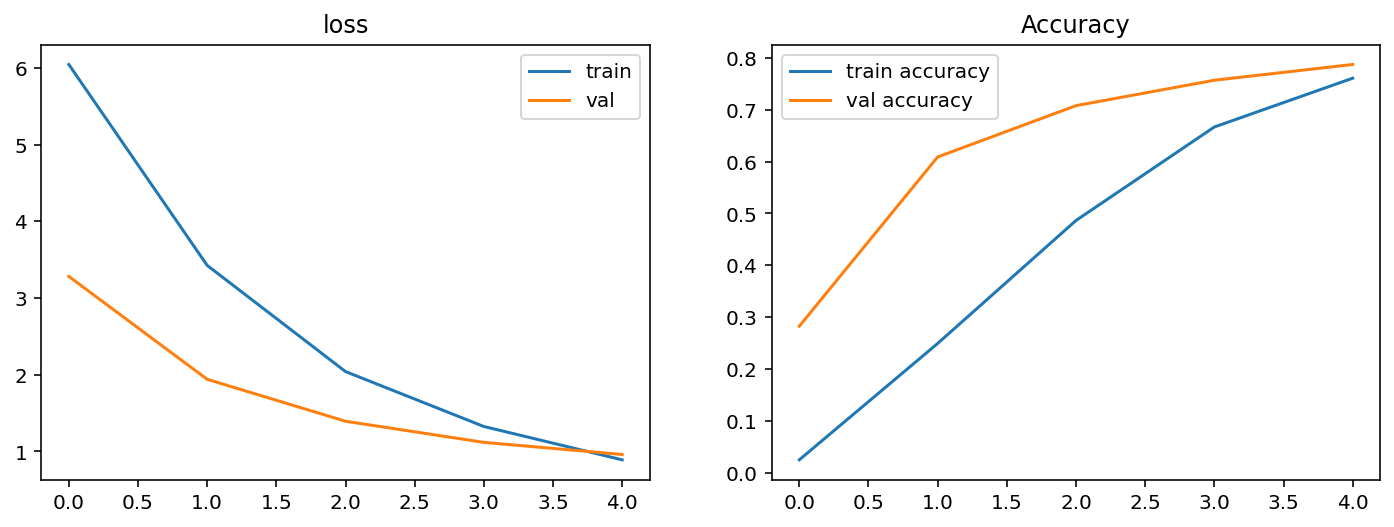

In [11]:
# Plot the loss and accuracy values achieved during training for the training and validation set
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)
plot_history(history)
plt.show()

## Testing the Network

In [12]:
# Print the loss and accuracy values achieved on the entire test set
results = model.evaluate(testing_batches)
print(f"loss: {results[0]}\naccuracy: {results[1]}")

193/193 [==============================] - 58s 300ms/step - loss: 1.1433 - accuracy: 0.7385
loss: 1.1432886123657227
accuracy: 0.7384940385818481


## Save the Model

In [13]:
# Save trained model as a Keras model
t = time.time()

saved_keras_model_filepath = './{}.h5'.format(int(t))

model.save(saved_keras_model_filepath)

## Load the Keras Model

In [14]:
# Load the Keras model
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath,custom_objects={'KerasLayer':hub.KerasLayer})

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5508713   
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 102)               102204    
                                                                 
Total params: 5,610,917
Trainable params: 102,204
Non-trainable params: 5,508,713
_________________________________________________________________


# Inference for Classification

Now I'll write a function that uses my trained network for inference. I'll write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. For example:

If `top_k=5` the output of the `predict` function will be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

### Image Pre-processing

In [16]:
# Create function for image pre-processing
def process_image(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image.numpy()

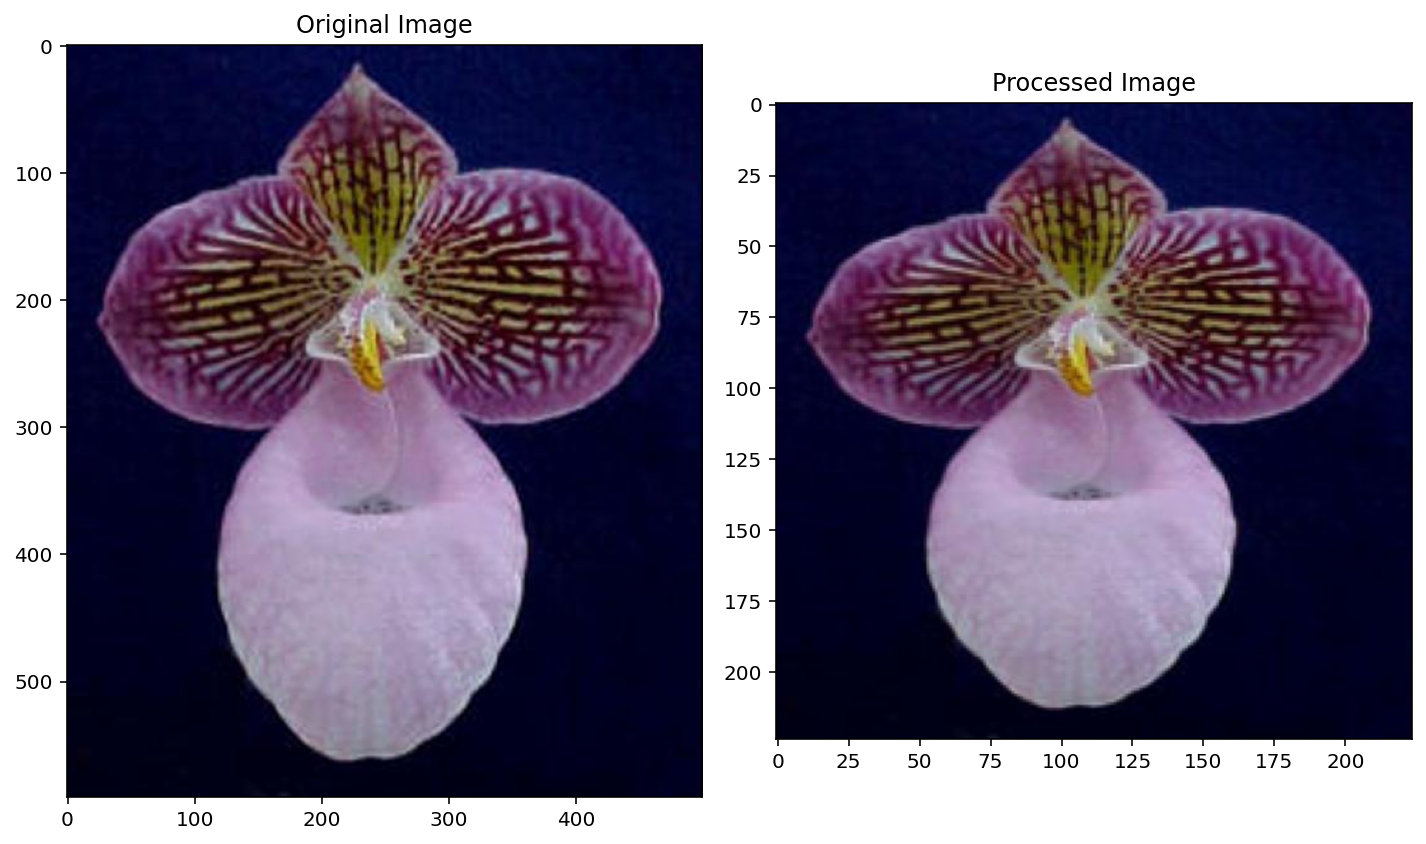

In [19]:
# Checking that the process_image function works as intended
image_path = './test_images/orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

### Inference

In [20]:
# Create the predict function
def predict(image_path, model, top_k):
    processed_test_image = process_image(np.asarray(Image.open(image_path)))
    probs = np.sort(model.predict(np.expand_dims(processed_test_image, axis=0)))[0][::-1]
    classes = np.add(np.argsort(model.predict(np.expand_dims(processed_test_image, axis=0)))[0][::-1], 1)
    classes_str = np.array(classes[:top_k], dtype='str')
    classes_return = []
    for class_str in classes_str:
        classes_return.append(class_names[class_str])
    return probs[:top_k], classes_return

Next, I'll export the predict function for use in a command-line application, in predict.py